In [1]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from readcount_tools import broken_zeta, add_largedot_legend
#import plotting constants
from readcount_tools import PAPER_CONTEXT, PAGEWIDTH_IN, POINTSIZE_HIGHLIGHT,POINTSIZE_SMALL,SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE,LINEWIDTH,POINTSIZE,TICKLENGTH,LEGEND_FONTSIZE,SPINEWIDTH,LETTER_LOC_X,LETTER_LOC_Y

### Load preproc results

In [2]:
basepath = 'data/reads_per_umi_tables/'

In [3]:
%%time
#1min30sec
with open(f'{basepath}reads_per_umi_dfs_hd1_preproc.pickle','rb') as f:
    dfs = pickle.load(f) 

tcmalloc: large alloc 1073741824 bytes == 0x769ac000 @ 
tcmalloc: large alloc 2147483648 bytes == 0xf125e000 @ 
tcmalloc: large alloc 4294967296 bytes == 0x1f74fc000 @ 


CPU times: user 45.7 s, sys: 27.2 s, total: 1min 12s
Wall time: 1min 12s


In [4]:
dfs_A = [df for df in dfs if not 'qB' in df.index[0]]
labels = [df.index[0] for df in dfs_A]

labels2pretty = dict(CELseq2A='CEL-seq2 (A)',
                  CELseq2B='CEL-seq2 (B)',
                    DropSeqA='Drop-seq',
                    MARSseqA='MARS-seq',
                    SCRBseqA='SCRB-seq',
                    Smartseq3_Fibroblast='Smart-seq3 (SE)',
                    Smartseq3_Fibroblast_PE='Smart-seq3 (PE)',
                    Smartseq3xpressA='Smart-seq3 (Xpress)')
pretty_labels = [labels2pretty[l] for l in labels]

### $\alpha_Z$ and E[Z] per cell (Figures S10/S11)

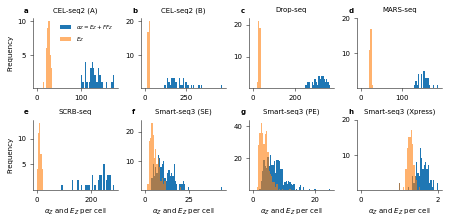

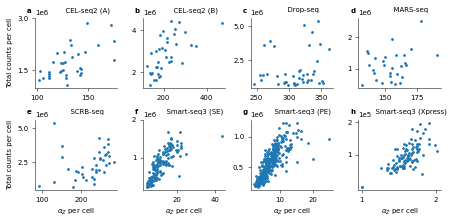

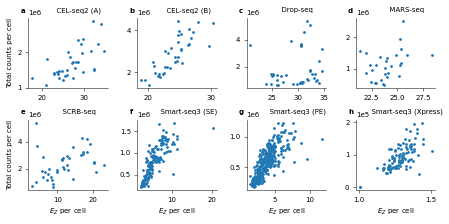

In [5]:
ncols = 4
nrows = 2
panelsize_in = PAGEWIDTH_IN/ncols
figheight_in = panelsize_in*nrows

path_hist='figures/S_single_cell_alpha_mean_hist.pdf'
path_alpha='figures/S_single_cell_alpha_scatter.pdf'
path_ez='figures/S_single_cell_mean_scatter.pdf'
with mpl.rc_context(PAPER_CONTEXT):


    fig_hist, axes = plt.subplots(2,4,figsize=(PAGEWIDTH_IN,figheight_in))
    fig_alpha,bxes = plt.subplots(2,4,figsize=(PAGEWIDTH_IN,figheight_in))
    fig_ez,   cxes = plt.subplots(2,4,figsize=(PAGEWIDTH_IN,figheight_in))

    for i,(df,ax,bx,cx,label) in enumerate(zip(dfs_A,axes.flatten(),bxes.flatten(),cxes.flatten(),pretty_labels)):


        cellstats = df.groupby('RG').agg({'N': [np.mean, np.var, np.sum]})
        cellstats[('N','alpha')] = cellstats[('N','mean')] + cellstats[('N','var')] / cellstats[('N','mean')]

        n_cells=cellstats.shape[0]

        alphas = cellstats[('N','alpha')]
        means = cellstats[('N','mean')]

        minval = np.min(np.concatenate([alphas,means]))
        maxval = np.max(np.concatenate([alphas,means]))
        nbins = min([30*2,int(n_cells)*2])
        bins = np.linspace(0,maxval,num=nbins)

        ax.hist(alphas,bins=bins,label=r'$\alpha_Z=E_Z + FF_Z$')    
        ax.set_title(f'{label}')
        n_per_bin,_,_ = ax.hist(means,bins=bins,label='$E_Z$',alpha=0.6)
        maxtick = np.round(np.max(n_per_bin)/10)*10
        ax.set_yticks(np.array([maxtick/2,maxtick]).astype(int))
        ax.set_xlabel(r'$\alpha_Z$ and $E_Z$ per cell')
        ax.set_ylabel('Frequency')        
        
        if i==0:
            ax.legend(frameon=False,fontsize=LEGEND_FONTSIZE)

        bx.set_title(f'          {label}')
        
        total_counts = cellstats[('N','sum')]
        bx.scatter(cellstats[('N','alpha')],total_counts,s=POINTSIZE_HIGHLIGHT)    
        
        max_total_counts = np.max(total_counts)
        scale_total_counts = 10**np.floor(np.log10(max_total_counts))
        maxtick = np.round(max_total_counts/scale_total_counts)*scale_total_counts
        bx.set_yticks(np.array([maxtick/2,maxtick]).astype(int))
        
        bx.set_xlabel(r'$\alpha_Z$ per cell')
        bx.set_ylabel('Total counts per cell')
        bx.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        cx.set_title(f'          {label}')
        cx.scatter(cellstats[('N','mean')],total_counts,s=POINTSIZE_HIGHLIGHT)    
        cx.set_xlabel(r'$E_Z$ per cell')
        cx.set_ylabel('Total counts per cell')
        cx.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for ax in np.concatenate([axes.flatten(),bxes.flatten(),cxes.flatten()]):
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
            
    letters=['a','b','c','d',
             'e','f','g','h']
    for xes in [axes, bxes, cxes]:
        for ax,letter, in zip(xes.flatten(),letters):
            ax.text(LETTER_LOC_X+0.2,LETTER_LOC_Y+0.13,letter,transform=ax.transAxes,fontweight='bold')
            
    for xes in [axes, bxes, cxes]:
        for irow,row in enumerate(xes):
            for icol,ax in enumerate(row):
                if irow==0:
                    ax.set_xlabel('')
                if icol>0:
                    ax.set_ylabel('')
    
            
    sns.despine(fig_hist)
    sns.despine(fig_alpha)
    sns.despine(fig_ez)
    fig_hist.tight_layout()
    fig_alpha.tight_layout()
    fig_ez.tight_layout()
    
    fig_hist.savefig(path_hist, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig_alpha.savefig(path_alpha, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig_ez.savefig(path_ez, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Look at Z distribution shape per cell

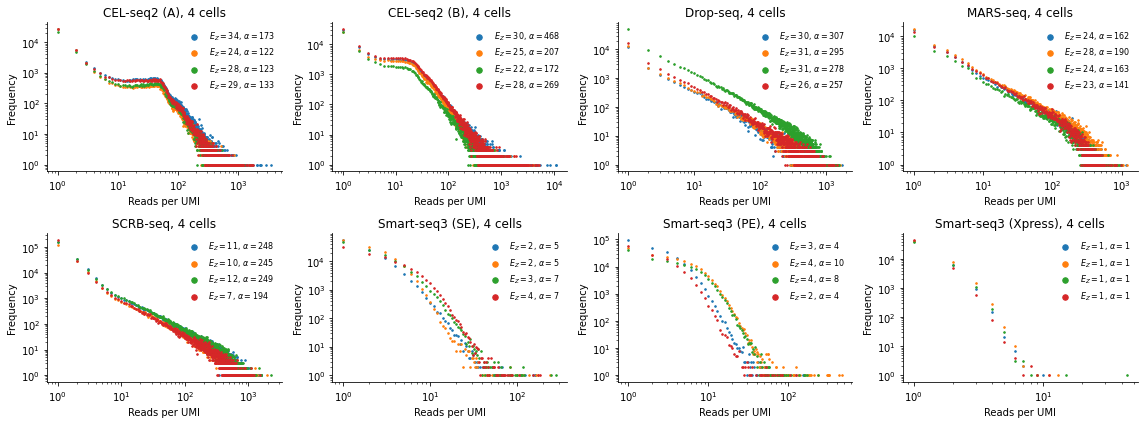

In [6]:
fig,axes = plt.subplots(2,4,figsize=(16,6))

for df,ax,label in zip(dfs_A,axes.flatten(),pretty_labels):

    cells = df.groupby('RG')

    for cell_i,(cellcode,cell) in enumerate(cells):
        Zs = cell['N']
        eZ = np.mean(Zs)
        ffZ = np.var(Zs)/eZ
        alpha = eZ + ffZ
        bins,counts = np.unique(Zs,return_counts=True)
        ax.scatter(bins,counts,s=2.5,lw=1,label=fr'$E_Z={eZ:.0f}$, $\alpha={alpha:.0f}$')
        ax.set_xscale('log')
        ax.set_yscale('log')
        add_largedot_legend(ax,loc='best',kwargs=dict(frameon=False,fontsize=8))
        if cell_i>=3:
            break
            
    ax.set_title(f'{label}, 4 cells')
    ax.set_xlabel('Reads per UMI')
    ax.set_ylabel('Frequency')

sns.despine()
plt.tight_layout()  